# Pure SGD Analysis: Testing the Bimodal Hypothesis

**Analyzing gradient updates from 1.9d (vanilla SGD, no optimizer)**

## Hypothesis

With batch_size=1 and pure SGD (no Adam), gradient updates should be:

1. **127 identical small vectors** - pointing away from h (wrong tokens)
2. **1 large vector** - pointing toward h (correct token)
3. **Perfectly bimodal** - cosine similarities at exactly +1 and -1
4. **1-dimensional** - PC1 explains ~100% of variance

## Questions to Answer

1. How many unique gradient vectors are there? (Predict: ~2)
2. How many non-unique vectors? (Predict: ~127)
3. Do magnitudes fall into two buckets? (Predict: yes, 1 big + 127 small)
4. Cosine similarities relative to largest gradient? (Predict: ~-1.0 for all small gradients)
5. Magnitude ratio: largest/smallest? (Predict: 10-100×)
6. Does the large gradient correspond to the correct token?
7. Do patterns persist across training steps?
8. Are the 127 small gradients exactly equal (bit-for-bit)?
9. PCA: does PC1 explain ~100% of variance?
10. Gradient norm histogram: two discrete peaks?

## Parameters

In [13]:
# Paths
TRAINING_DATA_PATH = '../tensors/Lil_Gatsby/1.9d_training_data.safetensors'
CORPUS_PATH = '../data/the_great_gatsby.txt'

# Analysis
STEPS_TO_ANALYZE = [1, 2, 3, 10, 50, 100, 500, 1000]

# Visualization
DPI = 200
COLORMAP = 'inferno'
RANDOM_SEED = 42

## Imports

In [14]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter

## Device Detection

In [15]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'Using device: {device}')

Using device: mps


## Load Data

In [16]:
# Load training data
data = load_file(TRAINING_DATA_PATH)

grads = data['grads']  # (1001, 128, 64)
embeddings = data['embeddings']
logits = data['logits']
dead_token_ids = data['dead_token_ids'].cpu().numpy()
live_token_ids = data['live_token_ids'].cpu().numpy()

print('Loaded training data (pure SGD):')
print(f'  Gradients: {grads.shape}')
print(f'  Steps: {grads.shape[0] - 1} (plus initial)')
print()

# Load corpus
with open(CORPUS_PATH, 'rb') as f:
    corpus_bytes = f.read()

print(f'Corpus: {len(corpus_bytes):,} bytes')

Loaded training data (pure SGD):
  Gradients: torch.Size([1001, 128, 64])
  Steps: 1000 (plus initial)

Corpus: 272,305 bytes


## Analysis Function

In [17]:
def analyze_step(step_num):
    """Comprehensive analysis of gradient structure at one step."""
    
    step_grads = grads[step_num].cpu().numpy()  # (128, 64)
    
    # Compute magnitudes
    mags = np.linalg.norm(step_grads, axis=1)
    
    # Find correct token (from corpus)
    if step_num > 0 and step_num <= len(corpus_bytes):
        correct_token = corpus_bytes[step_num - 1]
    else:
        correct_token = None
    
    # Find largest gradient
    largest_idx = np.argmax(mags)
    largest_grad = step_grads[largest_idx]
    largest_mag = mags[largest_idx]
    
    # Compute cosine similarities relative to largest gradient
    largest_norm = largest_grad / (largest_mag + 1e-10)
    all_norms = step_grads / (mags[:, None] + 1e-10)
    cosines_to_largest = all_norms @ largest_norm
    
    # Find unique gradients (exact bit-for-bit equality)
    unique_grads, inverse_indices = np.unique(step_grads, axis=0, return_inverse=True)
    n_unique = len(unique_grads)
    
    # Count duplicates
    unique_counts = np.bincount(inverse_indices)
    
    # PCA
    pca = PCA(n_components=min(10, step_grads.shape[0]))
    pca.fit(step_grads)
    
    return {
        'step': step_num,
        'grads': step_grads,
        'mags': mags,
        'largest_idx': largest_idx,
        'largest_mag': largest_mag,
        'correct_token': correct_token,
        'cosines_to_largest': cosines_to_largest,
        'n_unique': n_unique,
        'unique_counts': unique_counts,
        'pca': pca,
    }

print('✓ Analysis function defined')

✓ Analysis function defined


## Run Analysis on Selected Steps

In [18]:
print('='*70)
print('ANALYZING PURE SGD GRADIENT STRUCTURE')
print('='*70)
print()

results = []

for step in STEPS_TO_ANALYZE:
    if step >= grads.shape[0]:
        print(f'⚠ Step {step} exceeds available data')
        continue
    
    result = analyze_step(step)
    results.append(result)
    
    print(f"Step {step}:")
    print(f"  Correct token: {chr(result['correct_token']) if result['correct_token'] else 'N/A'} (ASCII {result['correct_token']})")
    print(f"  Largest gradient: token {result['largest_idx']} = '{chr(result['largest_idx'])}' (ASCII {result['largest_idx']})")
    print(f"  Match: {'✓' if result['largest_idx'] == result['correct_token'] else '✗'}")
    print()
    print(f"  Q1: Unique gradients: {result['n_unique']} / 128")
    print(f"  Q2: Duplicate gradients: {128 - result['n_unique']}")
    if result['n_unique'] <= 5:
        print(f"      Group sizes: {sorted(result['unique_counts'], reverse=True)}")
    print()
    print(f"  Q3: Magnitude buckets:")
    print(f"      Largest: {result['largest_mag']:.6f}")
    print(f"      Smallest: {result['mags'].min():.6f}")
    print(f"      Ratio: {result['largest_mag'] / result['mags'].min():.1f}×")
    print()
    print(f"  Q4: Cosines relative to largest:")
    print(f"      Min: {result['cosines_to_largest'].min():.8f}")
    print(f"      Max: {result['cosines_to_largest'].max():.8f}")
    print(f"      Mean (excluding largest): {np.delete(result['cosines_to_largest'], result['largest_idx']).mean():.8f}")
    print()
    print(f"  Q9: PCA dimensionality:")
    print(f"      PC1 variance: {result['pca'].explained_variance_ratio_[0]:.6f}")
    if len(result['pca'].explained_variance_ratio_) > 1:
        print(f"      PC2 variance: {result['pca'].explained_variance_ratio_[1]:.6f}")
    print()
    print('-'*70)
    print()

print('='*70)

ANALYZING PURE SGD GRADIENT STRUCTURE

Step 1:
  Correct token: T (ASCII 84)
  Largest gradient: token 32 = ' ' (ASCII 32)
  Match: ✗

  Q1: Unique gradients: 32 / 128
  Q2: Duplicate gradients: 96

  Q3: Magnitude buckets:
      Largest: 0.997243
      Smallest: 0.009255
      Ratio: 107.8×

  Q4: Cosines relative to largest:
      Min: -0.99950075
      Max: 1.00000000
      Mean (excluding largest): -0.61383849

  Q9: PCA dimensionality:
      PC1 variance: 0.996722
      PC2 variance: 0.000531

----------------------------------------------------------------------

Step 2:
  Correct token: h (ASCII 104)
  Largest gradient: token 32 = ' ' (ASCII 32)
  Match: ✗

  Q1: Unique gradients: 30 / 128
  Q2: Duplicate gradients: 98

  Q3: Magnitude buckets:
      Largest: 1.337560
      Smallest: 0.008804
      Ratio: 151.9×

  Q4: Cosines relative to largest:
      Min: -0.99958897
      Max: 1.00000000
      Mean (excluding largest): -0.68960482

  Q9: PCA dimensionality:
      PC1 varianc

## Q8: Test for Exact Equality Among Small Gradients

In [19]:
print('='*70)
print('Q8: ARE THE 127 SMALL GRADIENTS EXACTLY EQUAL?')
print('='*70)
print()

for result in results[:3]:  # Check first 3 steps in detail
    step = result['step']
    step_grads = result['grads']
    largest_idx = result['largest_idx']
    
    # Exclude the largest gradient
    small_grads = np.delete(step_grads, largest_idx, axis=0)
    
    # Check if all are exactly equal
    reference = small_grads[0]
    all_equal = np.all(small_grads == reference, axis=1).all()
    
    print(f"Step {step}:")
    if all_equal:
        print(f"  ✓ ALL 127 small gradients are EXACTLY EQUAL (bit-for-bit)")
    else:
        # Count how many are equal to reference
        equal_count = np.all(small_grads == reference, axis=1).sum()
        print(f"  ✗ Only {equal_count}/127 small gradients equal to reference")
        
        # Find unique small gradients
        unique_small = np.unique(small_grads, axis=0)
        print(f"  Unique small gradient vectors: {len(unique_small)}")
    print()

print('='*70)

Q8: ARE THE 127 SMALL GRADIENTS EXACTLY EQUAL?

Step 1:
  ✗ Only 45/127 small gradients equal to reference
  Unique small gradient vectors: 31

Step 2:
  ✗ Only 95/127 small gradients equal to reference
  Unique small gradient vectors: 29

Step 3:
  ✗ Only 40/127 small gradients equal to reference
  Unique small gradient vectors: 34



## Q10: Gradient Magnitude Distribution

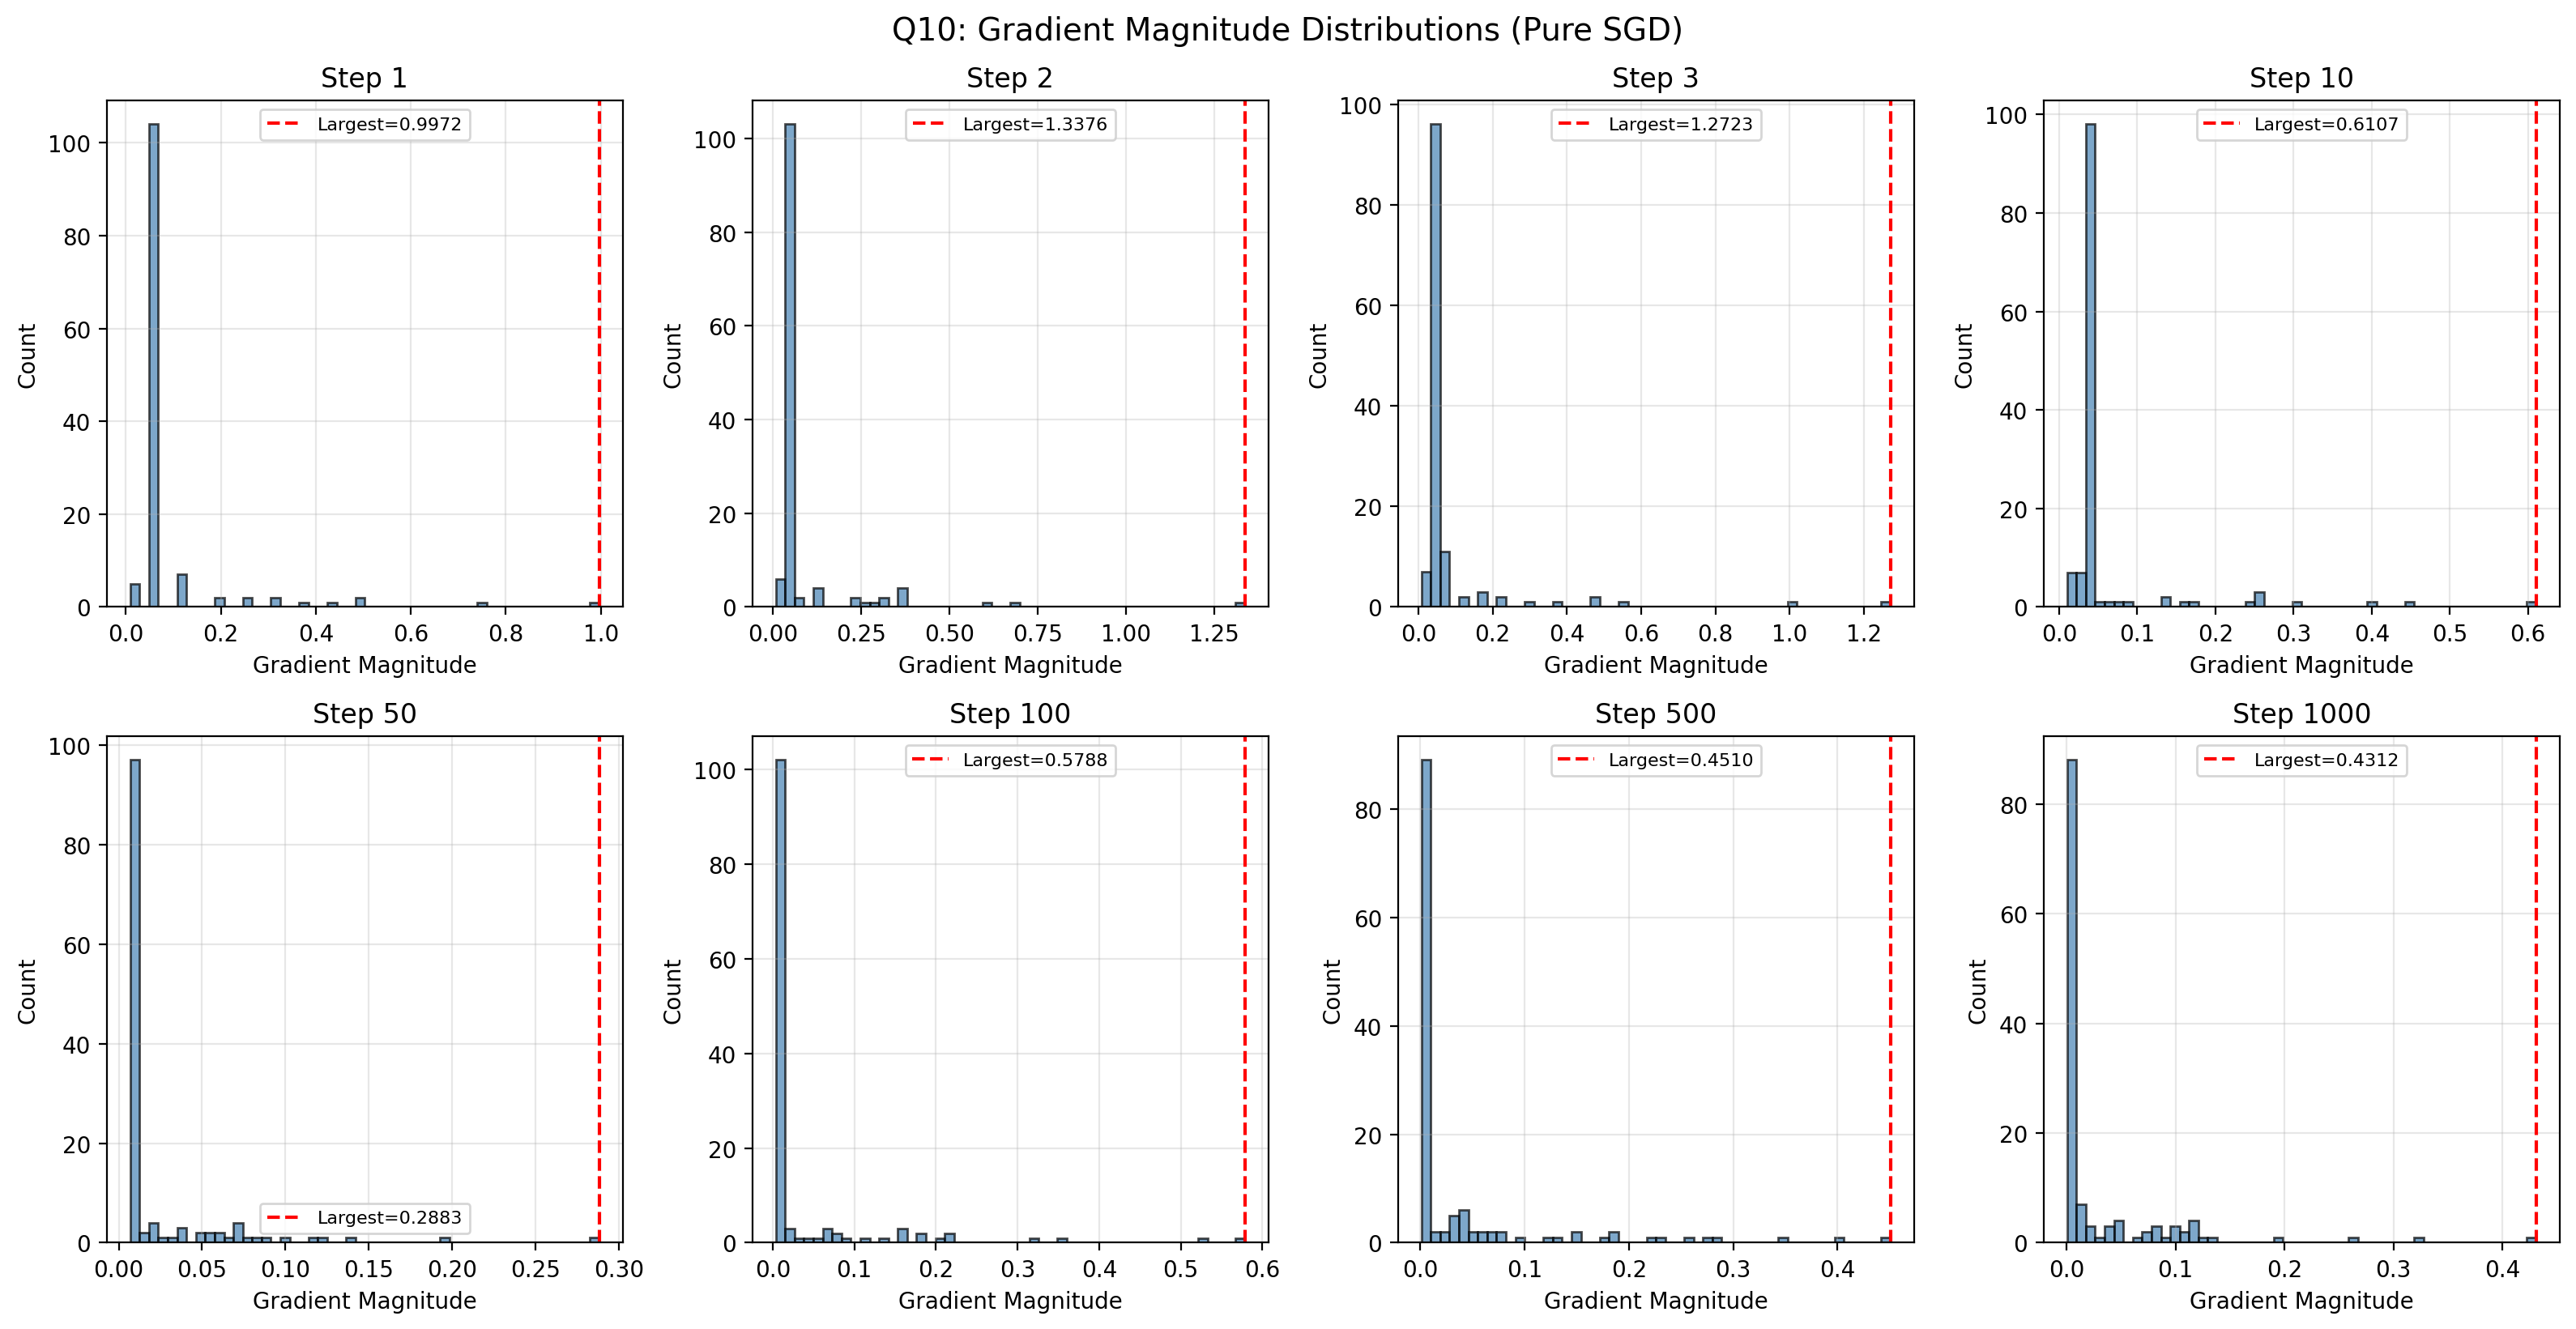

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), dpi=DPI)
axes = axes.flatten()

for i, result in enumerate(results):
    if i >= len(axes):
        break
    
    ax = axes[i]
    step = result['step']
    mags = result['mags']
    
    # Histogram
    ax.hist(mags, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax.axvline(result['largest_mag'], color='red', linestyle='--', 
               label=f'Largest={result["largest_mag"]:.4f}')
    ax.set_xlabel('Gradient Magnitude')
    ax.set_ylabel('Count')
    ax.set_title(f'Step {step}')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

# Hide unused
for i in range(len(results), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Q10: Gradient Magnitude Distributions (Pure SGD)', y=1.02, fontsize=14)
plt.show()

## Cosine Distribution Relative to Largest Gradient

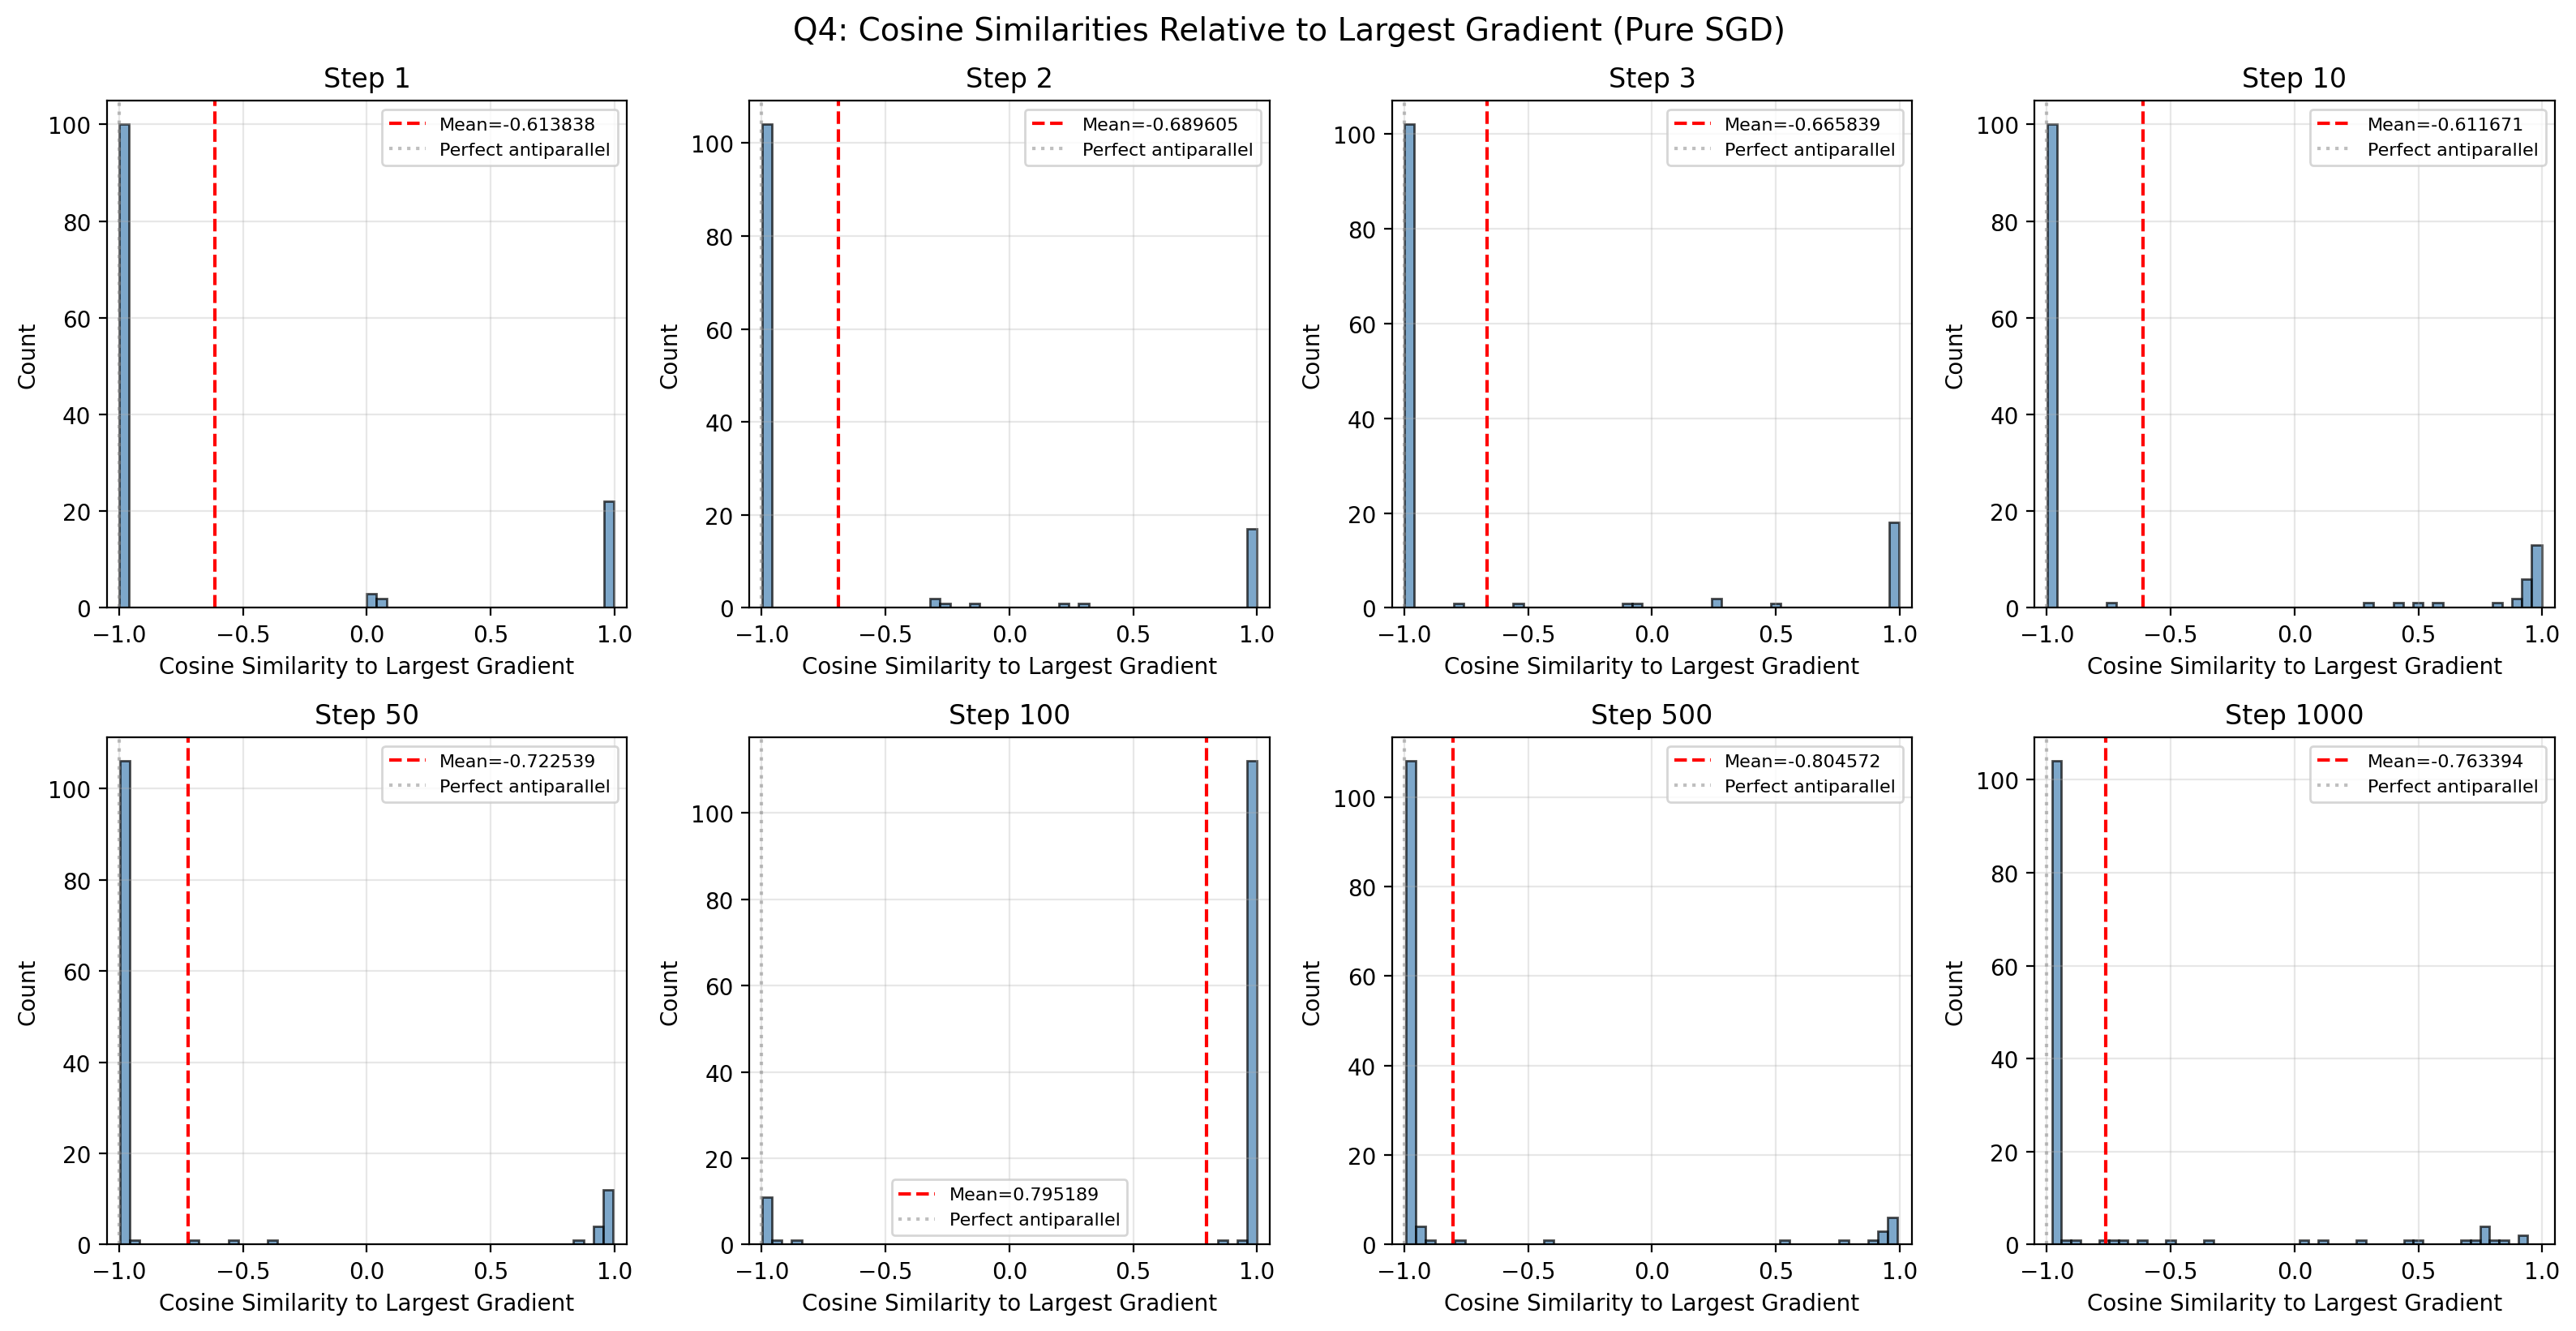

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), dpi=DPI)
axes = axes.flatten()

for i, result in enumerate(results):
    if i >= len(axes):
        break
    
    ax = axes[i]
    step = result['step']
    cosines = result['cosines_to_largest']
    
    # Exclude the largest gradient itself (cosine = 1.0)
    cosines_others = np.delete(cosines, result['largest_idx'])
    
    # Histogram
    ax.hist(cosines_others, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax.axvline(cosines_others.mean(), color='red', linestyle='--',
               label=f'Mean={cosines_others.mean():.6f}')
    ax.axvline(-1.0, color='gray', linestyle=':', alpha=0.5, label='Perfect antiparallel')
    ax.set_xlabel('Cosine Similarity to Largest Gradient')
    ax.set_ylabel('Count')
    ax.set_title(f'Step {step}')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.set_xlim(-1.05, 1.05)

# Hide unused
for i in range(len(results), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Q4: Cosine Similarities Relative to Largest Gradient (Pure SGD)', y=1.02, fontsize=14)
plt.show()

## PCA Explained Variance Evolution

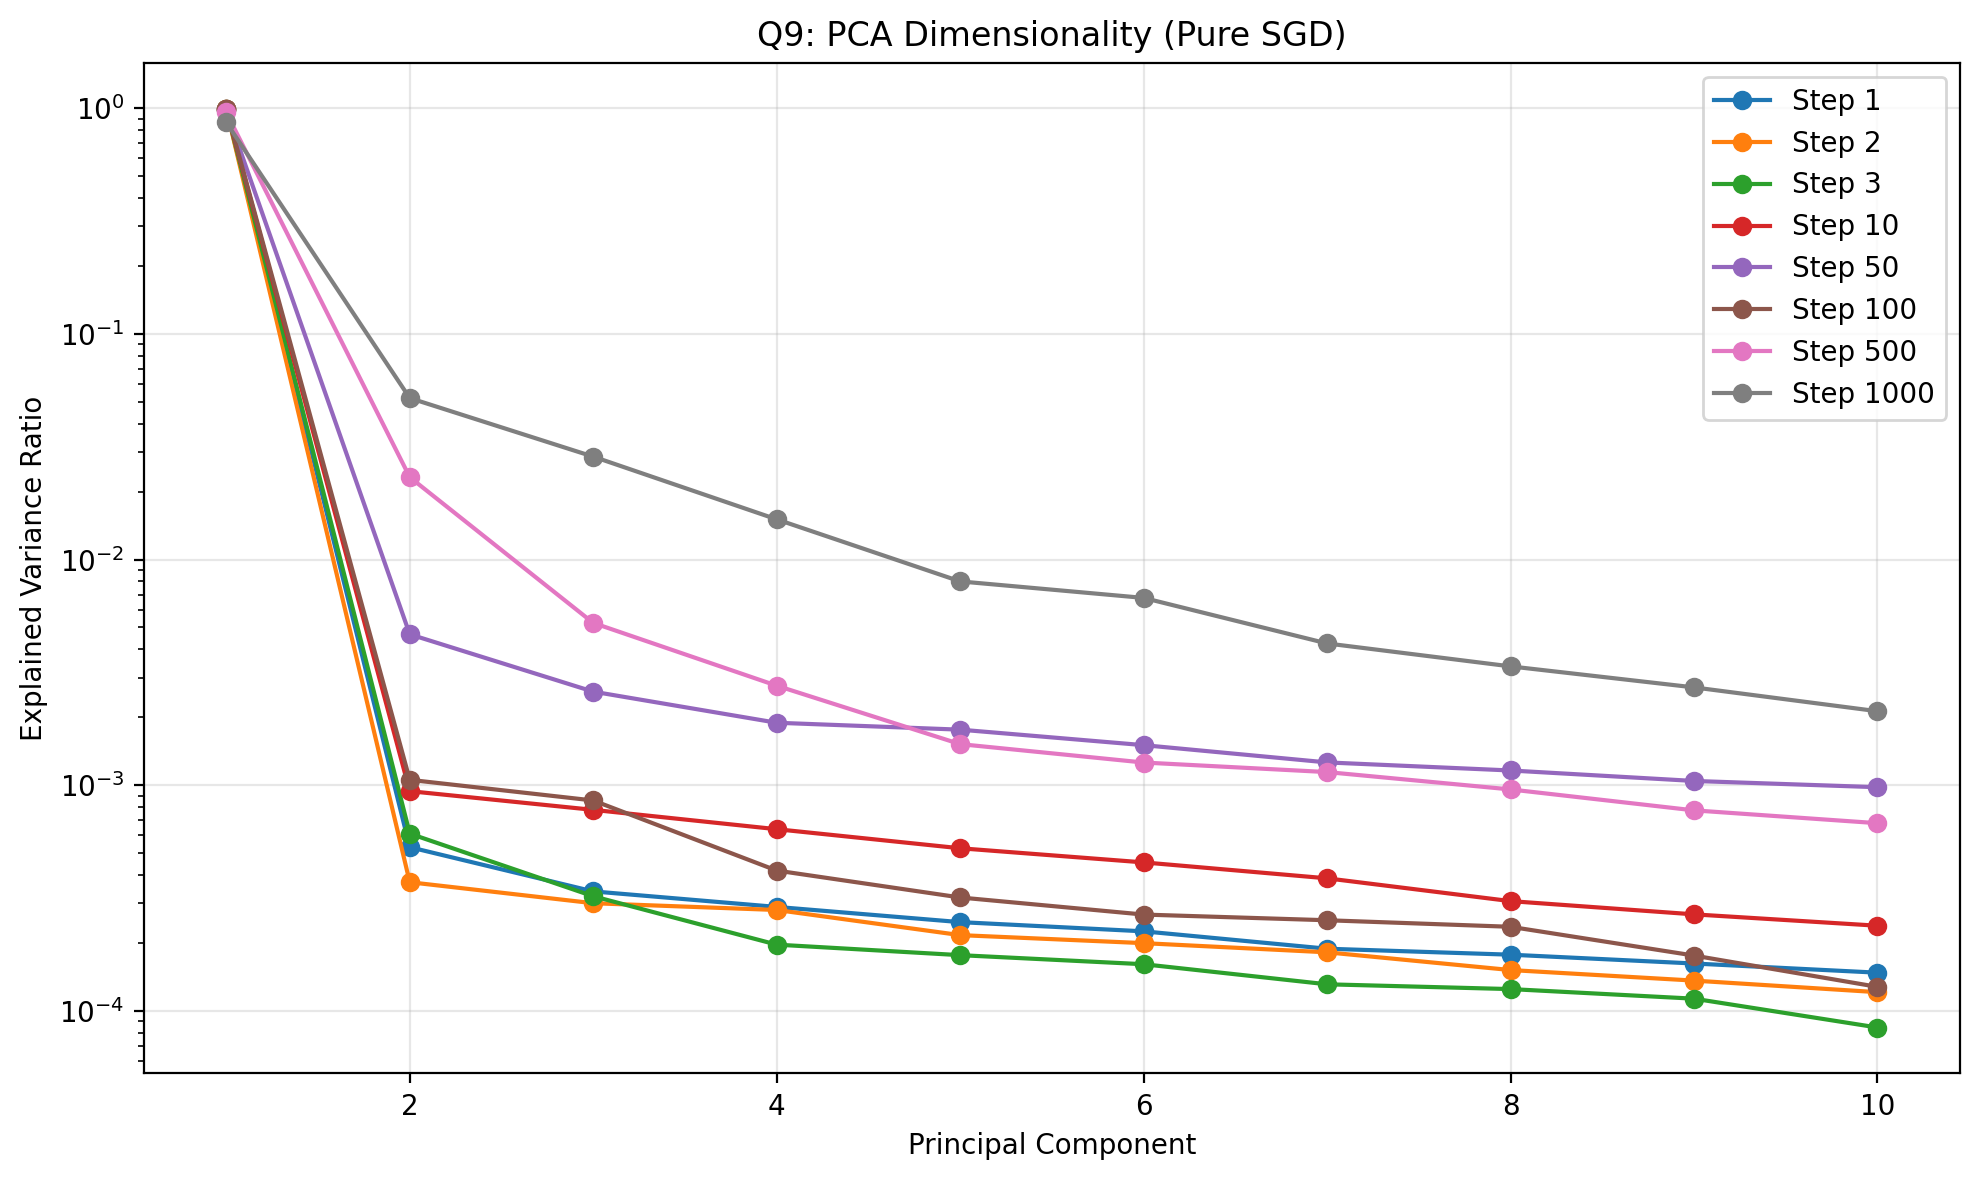

In [22]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

for result in results:
    step = result['step']
    pca = result['pca']
    n_components = len(pca.explained_variance_ratio_)
    
    ax.plot(range(1, n_components + 1), pca.explained_variance_ratio_,
            marker='o', label=f'Step {step}')

ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Q9: PCA Dimensionality (Pure SGD)')
ax.legend()
ax.grid(alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

## 2D Gradient Projections

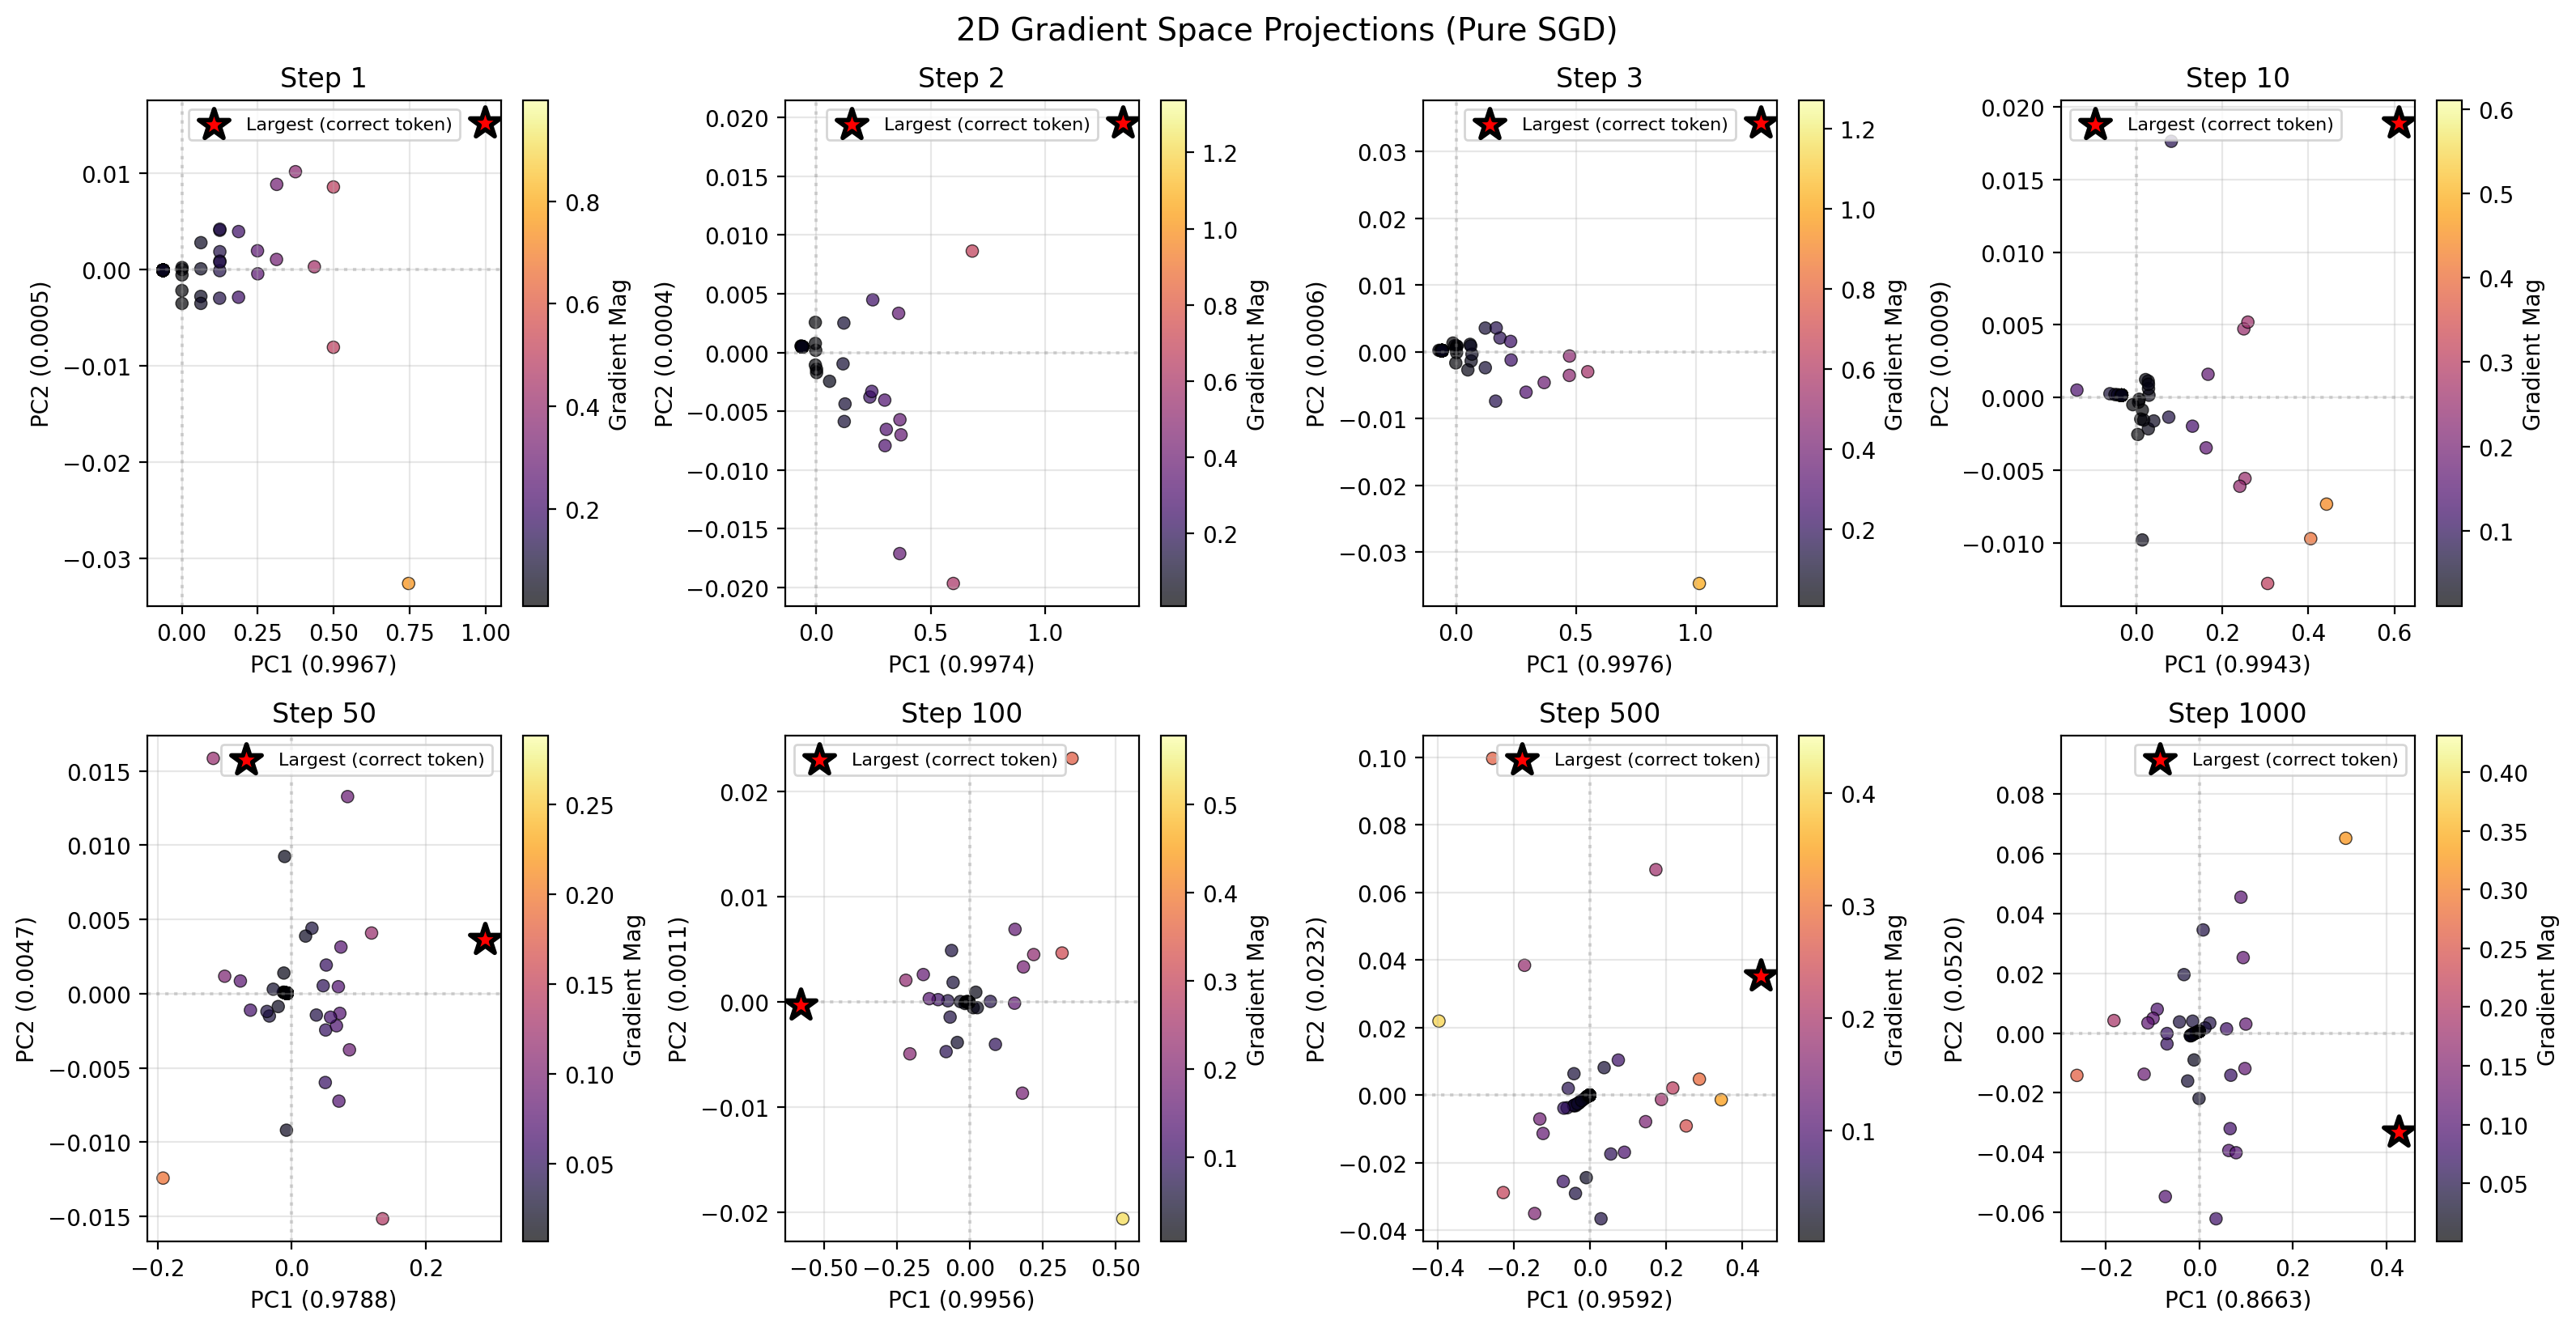

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), dpi=DPI)
axes = axes.flatten()

for i, result in enumerate(results):
    if i >= len(axes):
        break
    
    ax = axes[i]
    step = result['step']
    step_grads = result['grads']
    mags = result['mags']
    largest_idx = result['largest_idx']
    
    # Project to 2D
    pca = PCA(n_components=2, random_state=RANDOM_SEED)
    grads_2d = pca.fit_transform(step_grads)
    
    # Scatter
    scatter = ax.scatter(grads_2d[:, 0], grads_2d[:, 1], c=mags, cmap=COLORMAP,
                        s=30, alpha=0.7, edgecolors='black', linewidths=0.5)
    
    # Highlight largest
    ax.scatter(grads_2d[largest_idx, 0], grads_2d[largest_idx, 1],
              c='red', s=200, marker='*', edgecolors='black', linewidths=2,
              label='Largest (correct token)', zorder=10)
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.4f})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.4f})')
    ax.set_title(f'Step {step}')
    ax.grid(alpha=0.3)
    ax.axhline(0, color='gray', linestyle=':', alpha=0.3)
    ax.axvline(0, color='gray', linestyle=':', alpha=0.3)
    ax.legend(fontsize=8)
    
    plt.colorbar(scatter, ax=ax, label='Gradient Mag')

# Hide unused
for i in range(len(results), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('2D Gradient Space Projections (Pure SGD)', y=1.02, fontsize=14)
plt.show()

## Summary

In [24]:
print('='*70)
print('SUMMARY: PURE SGD GRADIENT ANALYSIS')
print('='*70)
print()
print('Hypothesis: With vanilla SGD (no optimizer), gradients should be:')
print('  - 127 identical small vectors (wrong tokens)')
print('  - 1 large vector (correct token)')
print('  - Perfectly bimodal (cosines at ±1)')
print('  - 1-dimensional (PC1 ≈ 100%)')
print()

# Check first step
r = results[0]
print(f'Results for Step {r["step"]}:')
print()
print(f'Q1: Unique gradients: {r["n_unique"]} / 128')
if r['n_unique'] <= 3:
    print('  ✓ CONFIRMED: ~2 unique gradients')
else:
    print(f'  ✗ UNEXPECTED: More than 2 unique gradients')
print()

print(f'Q2: Non-unique gradients: {128 - r["n_unique"]}')
if 128 - r['n_unique'] >= 125:
    print('  ✓ CONFIRMED: ~127 duplicates')
else:
    print(f'  ✗ UNEXPECTED: Fewer duplicates than expected')
print()

ratio = r['largest_mag'] / r['mags'].min()
print(f'Q3/Q5: Magnitude ratio: {ratio:.1f}×')
if ratio > 5:
    print('  ✓ CONFIRMED: Large ratio between biggest and smallest')
else:
    print('  ⚠ UNEXPECTED: Ratio smaller than expected')
print()

cosines_others = np.delete(r['cosines_to_largest'], r['largest_idx'])
mean_cos = cosines_others.mean()
print(f'Q4: Mean cosine (to largest): {mean_cos:.8f}')
if mean_cos < -0.95:
    print('  ✓ CONFIRMED: Nearly perfect antiparallel')
else:
    print(f'  ✗ UNEXPECTED: Not antiparallel ({mean_cos:.4f})')
print()

pc1_var = r['pca'].explained_variance_ratio_[0]
print(f'Q9: PC1 explained variance: {pc1_var:.6f}')
if pc1_var > 0.99:
    print('  ✓ CONFIRMED: Essentially 1-dimensional')
elif pc1_var > 0.95:
    print('  ~ MOSTLY CONFIRMED: Nearly 1-dimensional')
else:
    print(f'  ✗ UNEXPECTED: Multi-dimensional ({pc1_var:.4f})')
print()

print('='*70)

SUMMARY: PURE SGD GRADIENT ANALYSIS

Hypothesis: With vanilla SGD (no optimizer), gradients should be:
  - 127 identical small vectors (wrong tokens)
  - 1 large vector (correct token)
  - Perfectly bimodal (cosines at ±1)
  - 1-dimensional (PC1 ≈ 100%)

Results for Step 1:

Q1: Unique gradients: 32 / 128
  ✗ UNEXPECTED: More than 2 unique gradients

Q2: Non-unique gradients: 96
  ✗ UNEXPECTED: Fewer duplicates than expected

Q3/Q5: Magnitude ratio: 107.8×
  ✓ CONFIRMED: Large ratio between biggest and smallest

Q4: Mean cosine (to largest): -0.61383849
  ✗ UNEXPECTED: Not antiparallel (-0.6138)

Q9: PC1 explained variance: 0.996722
  ✓ CONFIRMED: Essentially 1-dimensional

